### This script contains the following:

#### 1. Importing libraries and data
#### 2. Subsetting, wrangling, and cleaning time-series data
#### 3. Time series analysis: decomposition
#### 4. Testing for stationarity
#### 5. Stationarizing the Sales Data

### 1. Importing libraries and data

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

from datetime import datetime


In [2]:
# Accessing EnvFile for path

%run EnvFile.ipynb


Stored 'path' (str)


In [3]:
# Import ".csv" file for the SaaS sales dataset.

df = pd.read_csv(os.path.join(path, '01 Data', 'SaaS-Sales.csv'))


In [4]:
df.head()

,Row ID,Order ID,Order Date,Date Key,Contact Name,Country,City,Region,Subregion,Customer,Customer ID,Industry,Segment,Product,License,Sales,Quantity,Discount,Profit
0,1,EMEA-2022-152156,11/09/22,20221109,Nathan Bell,Ireland,Dublin,EMEA,UKIR,Chevron,1017,Energy,SMB,Marketing Suite,16GRM07R1K,261.9600,2,0.00,41.9136
1,2,EMEA-2022-152156,11/09/22,20221109,Nathan Bell,Ireland,Dublin,EMEA,UKIR,Chevron,1017,Energy,SMB,FinanceHub,QLIW57KZUV,731.9400,3,0.00,219.5820
2,3,AMER-2022-138688,6/13/2022,20220613,Deirdre Bailey,United States,New York City,AMER,NAMER,Phillips 66,1056,Energy,Strategic,FinanceHub,JI6BVL70HQ,14.6200,2,0.00,6.8714
3,4,EMEA-2021-108966,10/11/21,20211011,Zoe Hodges,Germany,Stuttgart,EMEA,EU-WEST,Royal Dutch Shell,1031,Energy,SMB,ContactMatcher,DE9GJKGD44,957.5775,5,0.45,-383.0310
4,5,EMEA-2021-108966,10/11/21,20211011,Zoe Hodges,Germany,Stuttgart,EMEA,EU-WEST,Royal Dutch Shell,1031,Energy,SMB,Marketing Suite - Gold,OIF7NY23WD,22.3680,2,0.20,2.5164


In [5]:
df.describe()

,Row ID,Date Key,Customer ID,Sales,Quantity,Discount,Profit
count,9994.000000,9.994000e+03,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000
mean,4997.500000,2.021803e+07,1049.771963,229.858001,3.789574,0.156203,28.656896
std,2885.163629,1.123898e+04,29.719388,623.245101,2.225110,0.206452,234.260108
min,1.000000,2.020010e+07,1001.000000,0.444000,1.000000,0.000000,-6599.978000
25%,2499.250000,2.021052e+07,1024.000000,17.280000,2.000000,0.000000,1.728750
50%,4997.500000,2.022063e+07,1049.000000,54.490000,3.000000,0.200000,8.666500
75%,7495.750000,2.023052e+07,1076.000000,209.940000,5.000000,0.200000,29.364000
max,9994.000000,2.023123e+07,1101.000000,22638.480000,14.000000,0.800000,8399.976000


### 2. Subsetting, wrangling, and cleaning time-series data

In [6]:
def find_date_formats_and_unique_strings(df, column_name):
    date_formats_found = set()
    unique_strings_found = set()
    for value in df[column_name]:
        if pd.notnull(value):
            # Try to parse the value as a date format
            for date_format in ["%d/%m/%Y", "%m/%d/%Y", "%d/%m/%y", "%m/%d/%y", "%m.%d.%Y", "%m.%d.%y", "%d.%m.%Y", "%d.%m.%y"]:
                try:
                    datetime.strptime(str(value), date_format)
                    date_formats_found.add(date_format)
                    break  # Break the loop if a date format is found
                except ValueError:
                    pass
            else:
                # If the value is not a date, add it to the unique_strings_found set
                unique_strings_found.add(str(value))
    return date_formats_found, unique_strings_found

In [7]:
def convert_to_ddmmyyyy(value):
    for date_format in ["%d/%m/%Y", "%m/%d/%Y", "%d/%m/%y", "%m/%d/%y", "%m.%d.%Y", "%m.%d.%y", "%d.%m.%Y", "%d.%m.%y"]:
        try:
            date_object = datetime.strptime(str(value), date_format)
            return date_object.strftime("%d/%m/%Y")
        except ValueError:
            pass
    return str(value)

In [8]:
# Find date formats and unique string values present in the 'Date' column of the DataFrame
date_formats, unique_strings = find_date_formats_and_unique_strings(df, 'Order Date')

print("Order Date before formatting:")

print("Date Formats found:")
print(date_formats)

print("\nUnique String Values found:")
print(unique_strings)

Order Date before formatting:
Date Formats found:
{'%m/%d/%Y', '%d/%m/%y'}

Unique String Values found:
set()


In [9]:
# Convert the 'Date' column to the desired format
df['Order Date'] = df['Order Date'].apply(convert_to_ddmmyyyy)


In [10]:
# Find date formats and unique string values present in the 'Date' column of the DataFrame
date_formats, unique_strings = find_date_formats_and_unique_strings(df, 'Order Date')

print("Order Date after formatting:")

print("Date Formats found:")
print(date_formats)

print("\nUnique String Values found:")
print(unique_strings)

Order Date after formatting:
Date Formats found:
{'%d/%m/%Y'}

Unique String Values found:
set()


In [11]:
df['Order Date'].value_counts(dropna = False)

09/06/2022    38
09/03/2023    36
11/11/2022    35
12/02/2023    34
12/03/2023    34
              ..
25/02/2022     1
26/10/2022     1
22/02/2020     1
19/10/2022     1
22/01/2020     1
Name: Order Date, Length: 1237, dtype: int64

In [12]:
# Convert the 'order_date' column to a pandas datetime format
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d/%m/%Y')

In [13]:
# Define the upper limit for filtering (31/07/2023)
upper_limit = pd.Timestamp('2023-06-30')

In [14]:
# Filter the DataFrame to include only dates up to 31/07/2023
filtered_df = df[df['Order Date'] <= upper_limit]

In [15]:
# Find the latest date in the filtered DataFrame

latest_date_filtered = filtered_df['Order Date'].max()

In [16]:
print("Latest Date in Filtered DataFrame:", latest_date_filtered)

Latest Date in Filtered DataFrame: 2023-06-30 00:00:00


In [17]:
filtered_df['Order Date'].value_counts(dropna = False)

2022-06-09    38
2023-03-09    36
2022-11-11    35
2023-02-12    34
2023-03-12    34
              ..
2022-02-25     1
2022-10-26     1
2020-02-22     1
2020-11-09     1
2020-01-22     1
Name: Order Date, Length: 1069, dtype: int64

In [18]:
filtered_df.sort_values(by='Order Date', axis=0, inplace=True)

In [19]:
filtered_df.head()

,Row ID,Order ID,Order Date,Date Key,Contact Name,Country,City,Region,Subregion,Customer,Customer ID,Industry,Segment,Product,License,Sales,Quantity,Discount,Profit
3365,3366,AMER-2020-115161,2020-01-02,20200201,Jan White,United States,Yonkers,AMER,NAMER,Lukoil,1044,Energy,SMB,Marketing Suite,G146C50CFX,290.666,2,0.15,3.4196
7950,7951,APJ-2020-131009,2020-01-03,20200301,Benjamin Hughes,Japan,Shizuoka,APJ,JAPN,Apple,1008,Tech,SMB,Marketing Suite - Gold,J0YAAN3T86,129.552,3,0.20,-22.6716
157,158,AMER-2020-104269,2020-01-03,20200301,Anthony Sanderson,Canada,Toronto,AMER,NAMER,American Express,1005,Finance,SMB,FinanceHub,TJX5D1WJAN,457.568,2,0.20,51.4764
7948,7949,APJ-2020-131009,2020-01-03,20200301,Benjamin Hughes,Japan,Shizuoka,APJ,JAPN,Apple,1008,Tech,SMB,FinanceHub,QUXMUJ840K,362.250,6,0.30,0.0000
7947,7948,APJ-2020-131009,2020-01-03,20200301,Benjamin Hughes,Japan,Shizuoka,APJ,JAPN,Apple,1008,Tech,SMB,Storage,6VOG0TZLB5,18.840,5,0.20,-3.5325


In [20]:
# Set the "Order Date" column as the index

filtered_df = filtered_df.set_index('Order Date') # Set the datetime as the index of the dataframe.

In [21]:
filtered_df.head()

,Row ID,Order ID,Date Key,Contact Name,Country,City,Region,Subregion,Customer,Customer ID,Industry,Segment,Product,License,Sales,Quantity,Discount,Profit
Order Date,,,,,,,,,,,,,,,,,,
2020-01-02,3366,AMER-2020-115161,20200201,Jan White,United States,Yonkers,AMER,NAMER,Lukoil,1044,Energy,SMB,Marketing Suite,G146C50CFX,290.666,2,0.15,3.4196
2020-01-03,7951,APJ-2020-131009,20200301,Benjamin Hughes,Japan,Shizuoka,APJ,JAPN,Apple,1008,Tech,SMB,Marketing Suite - Gold,J0YAAN3T86,129.552,3,0.20,-22.6716
2020-01-03,158,AMER-2020-104269,20200301,Anthony Sanderson,Canada,Toronto,AMER,NAMER,American Express,1005,Finance,SMB,FinanceHub,TJX5D1WJAN,457.568,2,0.20,51.4764
2020-01-03,7949,APJ-2020-131009,20200301,Benjamin Hughes,Japan,Shizuoka,APJ,JAPN,Apple,1008,Tech,SMB,FinanceHub,QUXMUJ840K,362.250,6,0.30,0.0000
2020-01-03,7948,APJ-2020-131009,20200301,Benjamin Hughes,Japan,Shizuoka,APJ,JAPN,Apple,1008,Tech,SMB,Storage,6VOG0TZLB5,18.840,5,0.20,-3.5325


In [22]:
filtered_df.shape

(8141, 18)

In [23]:
df.shape

(9994, 19)

In [24]:
# Resample data to monthly frequency (you can choose a different frequency)
df_monthly = filtered_df.resample('M').sum()

In [25]:
df_monthly.head()

,Row ID,Date Key,Customer ID,Sales,Quantity,Discount,Profit
Order Date,,,,,,,
2020-01-31,574624,2626067170,136467,28484.806,502,17.90,4343.1386
2020-02-29,468321,1717060341,89075,13129.930,315,14.30,2829.4264
2020-03-31,900390,3393681282,175785,54899.992,616,31.60,62.7389
2020-04-30,526164,2383668014,123439,24401.132,460,13.00,4653.0309
2020-05-31,771426,3090697539,161283,30042.742,565,22.55,3892.5190


In [26]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
# Apply exponential smoothing
alpha = 0.2  # Smoothing parameter
df_monthly['ES Sales'] = ExponentialSmoothing(df_monthly['Sales'], initialization_method='estimated').fit(smoothing_level=alpha).fittedvalues

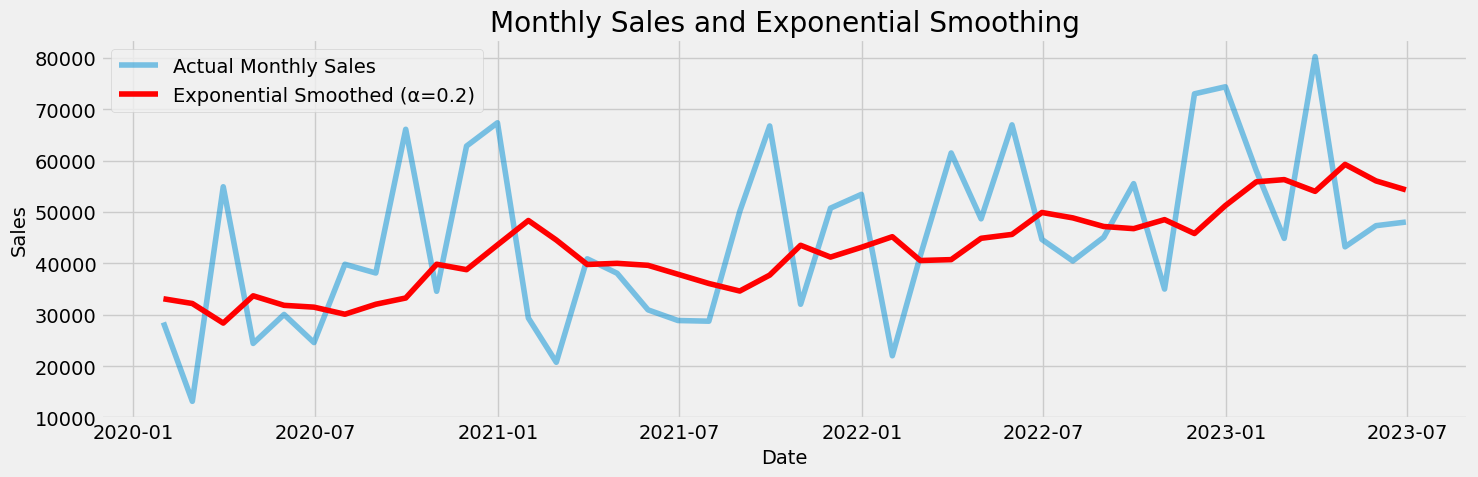

In [27]:
# Plot original monthly sales data and exponentially smoothed values
plt.figure(figsize=(15, 5), dpi=100)
plt.plot(df_monthly.index, df_monthly['Sales'], label='Actual Monthly Sales', alpha=0.5)
plt.plot(df_monthly.index, df_monthly['ES Sales'], label=f'Exponential Smoothed (α={alpha})', color='red')
plt.title('Monthly Sales and Exponential Smoothing')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

In [28]:
df_sales = df_monthly[['ES Sales']]

In [29]:
df_sales.shape

(42, 1)

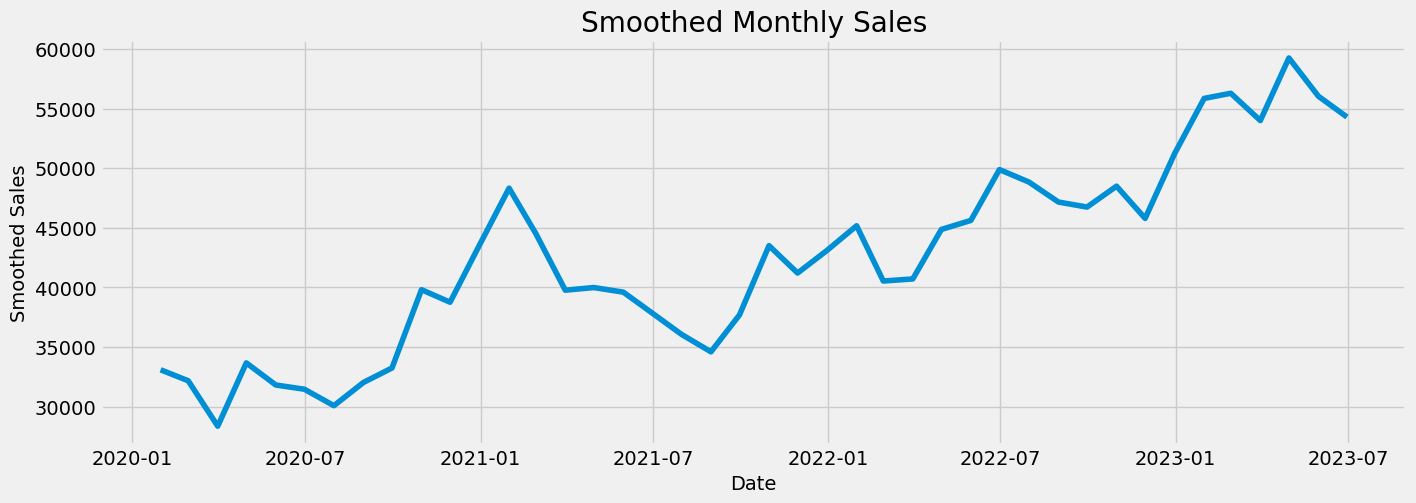

In [30]:
# Plot the new data set
plt.figure(figsize=(15, 5), dpi=100)
plt.plot(df_sales)
plt.title('Smoothed Monthly Sales')
plt.xlabel('Date')
plt.ylabel('Smoothed Sales')
plt.grid(True)
plt.show()

In [31]:
# Check for missing values (you shouldn't have any)

df_sales.isnull().sum()

ES Sales    0
dtype: int64

In [32]:
# Check for duplicates

dups = df_sales.duplicated()
dups.sum()

# No dups!

0

### 3. Time-series analysis: decomposition

In [33]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(df_sales, model='additive')

In [34]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

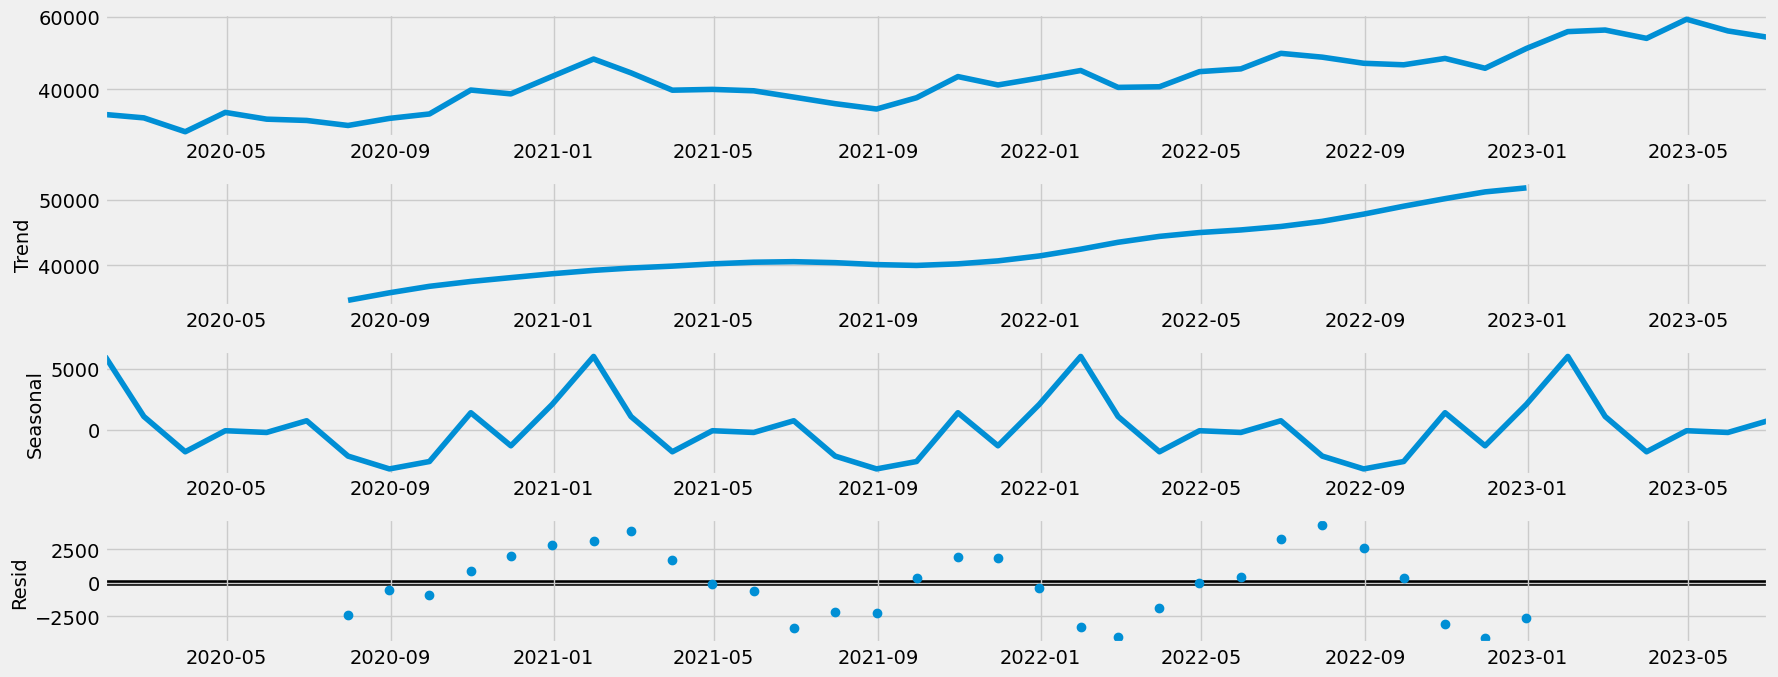

In [35]:
# Plot the separate components

decomposition.plot()
plt.show()

In [36]:
# Decompose the time series using the multiplicative model

decomposition = sm.tsa.seasonal_decompose(df_sales, model='multiplicative')

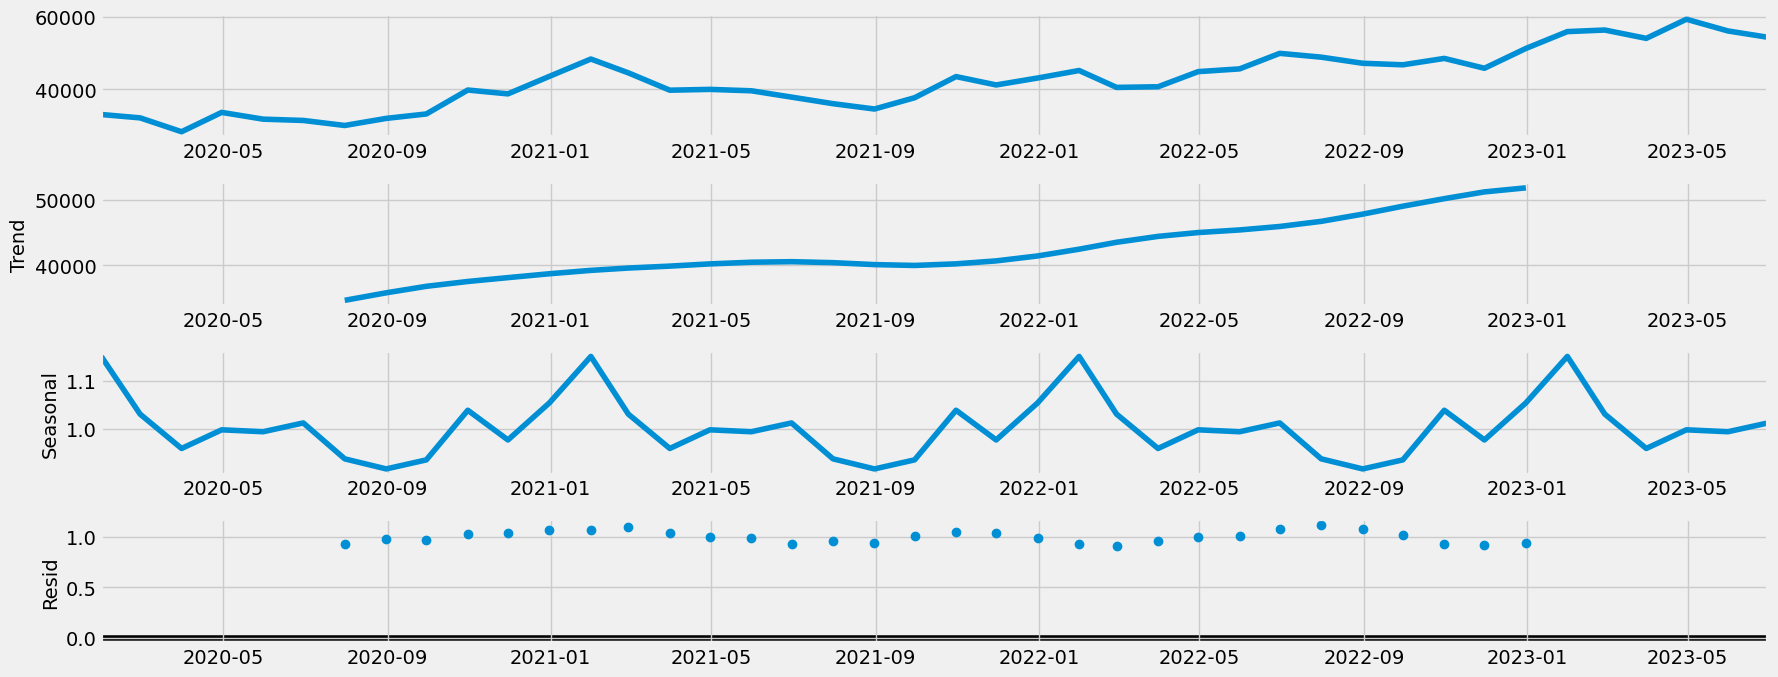

In [37]:
# Plot the separate components

decomposition.plot()
plt.show()

### 4. Testing for stationarity

In [38]:
df_sales.head()

,ES Sales
Order Date,
2020-01-31,33094.940457
2020-02-29,32172.913566
2020-03-31,28364.316853
2020-04-30,33671.451882
2020-05-31,31817.387906


In [39]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(df_sales['ES Sales'])

Dickey-Fuller Stationarity test:
Test Statistic                 -1.103845
p-value                         0.713536
Number of Lags Used             0.000000
Number of Observations Used    41.000000
Critical Value (1%)            -3.600983
Critical Value (5%)            -2.935135
Critical Value (10%)           -2.605963
dtype: float64


#### Test statistic is larger than critical value. Hence, can’t reject null hypothesis indicating there is a unit root in the data, and the data is non-stationary.

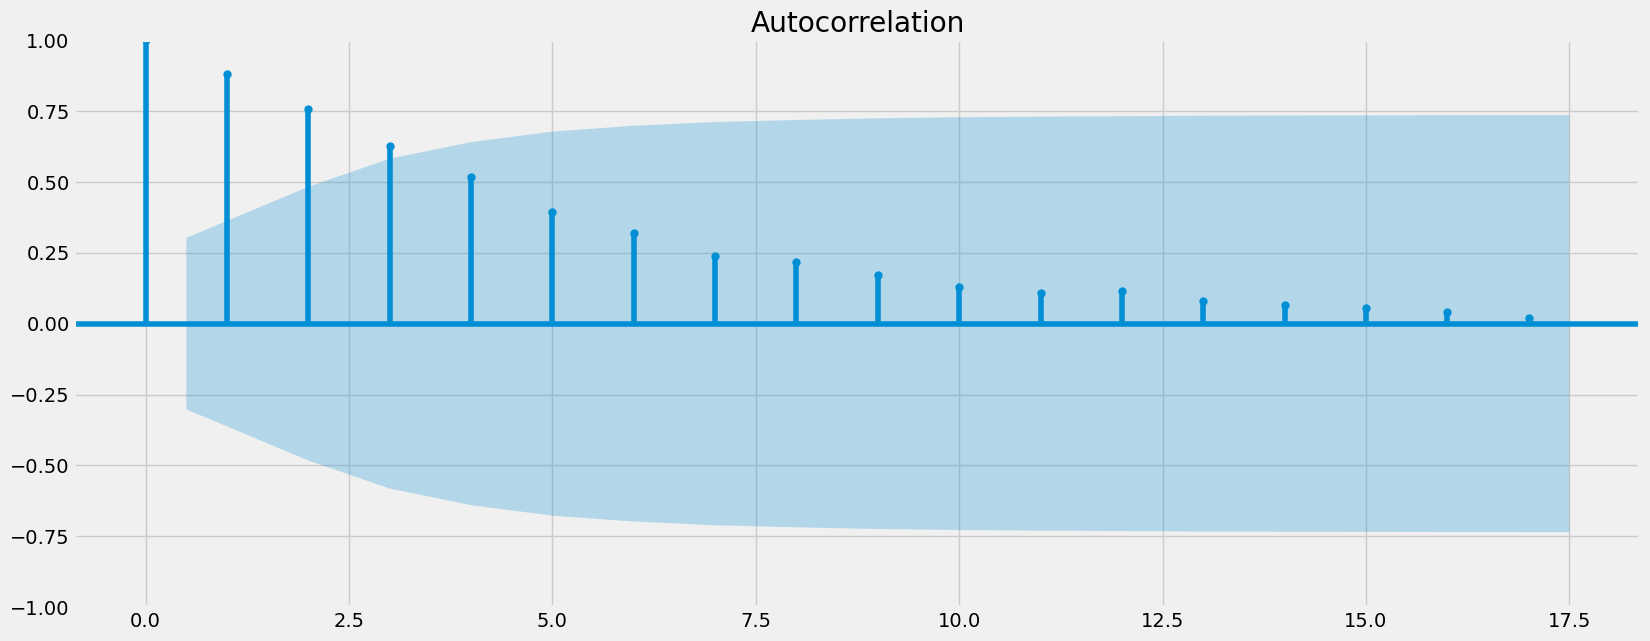

In [40]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(df_sales)
plt.show()

### 5. Stationarizing the Sales Data

In [41]:
df_sales_diff = df_sales - df_sales.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [42]:
df_sales_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [43]:
df_sales_diff.head()

,ES Sales
Order Date,
2020-02-29,-922.026891
2020-03-31,-3808.596713
2020-04-30,5307.135029
2020-05-31,-1854.063976
2020-06-30,-354.929181


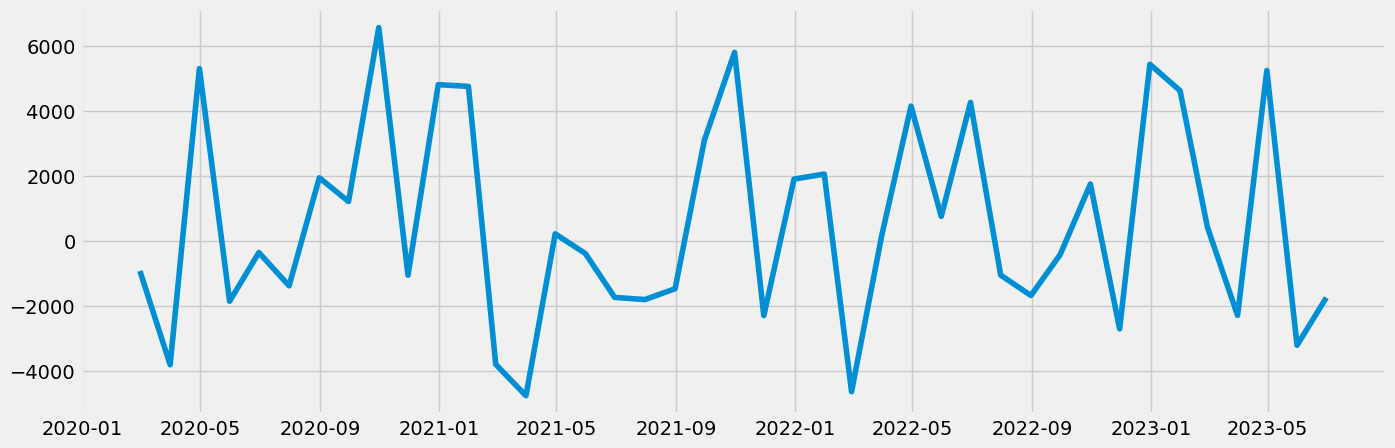

In [44]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(df_sales_diff)

In [45]:
dickey_fuller(df_sales_diff)

Dickey-Fuller Stationarity test:
Test Statistic                 -4.098676
p-value                         0.000973
Number of Lags Used             6.000000
Number of Observations Used    34.000000
Critical Value (1%)            -3.639224
Critical Value (5%)            -2.951230
Critical Value (10%)           -2.614447
dtype: float64


#### Test statistic is smaller than critical value and the p-value is also less than 0.05. Hence, can reject null hypothesis indicating there is no unit root in the data, and the data is stationary.

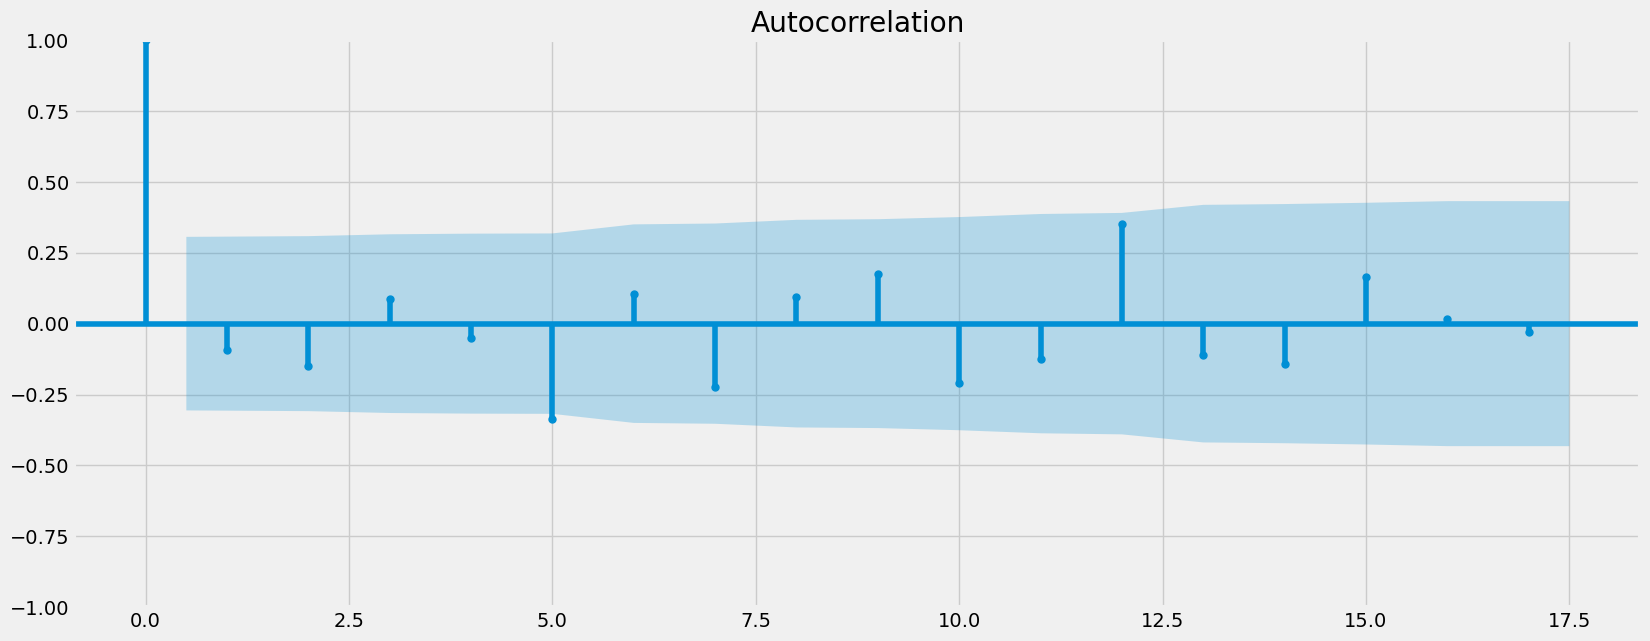

In [46]:
plot_acf(df_sales_diff)
plt.show()

In [47]:
df_monthly.head()

,Row ID,Date Key,Customer ID,Sales,Quantity,Discount,Profit,ES Sales
Order Date,,,,,,,,
2020-01-31,574624,2626067170,136467,28484.806,502,17.90,4343.1386,33094.940457
2020-02-29,468321,1717060341,89075,13129.930,315,14.30,2829.4264,32172.913566
2020-03-31,900390,3393681282,175785,54899.992,616,31.60,62.7389,28364.316853
2020-04-30,526164,2383668014,123439,24401.132,460,13.00,4653.0309,33671.451882
2020-05-31,771426,3090697539,161283,30042.742,565,22.55,3892.5190,31817.387906


In [49]:
# Assuming you have your final DataFrame df_monthly ready

# Export the DataFrame to an Excel file
# output_file = 'smoothed_sales_data.xlsx'  # Specify the desired output file name
df_monthly.to_excel(os.path.join(path, '01 Data', 'smoothed_sales_data.xlsx'), index = True)  # Set index=True to include the index (dates) in the exported file

In [50]:
filtered_df.head()

,Row ID,Order ID,Date Key,Contact Name,Country,City,Region,Subregion,Customer,Customer ID,Industry,Segment,Product,License,Sales,Quantity,Discount,Profit
Order Date,,,,,,,,,,,,,,,,,,
2020-01-02,3366,AMER-2020-115161,20200201,Jan White,United States,Yonkers,AMER,NAMER,Lukoil,1044,Energy,SMB,Marketing Suite,G146C50CFX,290.666,2,0.15,3.4196
2020-01-03,7951,APJ-2020-131009,20200301,Benjamin Hughes,Japan,Shizuoka,APJ,JAPN,Apple,1008,Tech,SMB,Marketing Suite - Gold,J0YAAN3T86,129.552,3,0.20,-22.6716
2020-01-03,158,AMER-2020-104269,20200301,Anthony Sanderson,Canada,Toronto,AMER,NAMER,American Express,1005,Finance,SMB,FinanceHub,TJX5D1WJAN,457.568,2,0.20,51.4764
2020-01-03,7949,APJ-2020-131009,20200301,Benjamin Hughes,Japan,Shizuoka,APJ,JAPN,Apple,1008,Tech,SMB,FinanceHub,QUXMUJ840K,362.250,6,0.30,0.0000
2020-01-03,7948,APJ-2020-131009,20200301,Benjamin Hughes,Japan,Shizuoka,APJ,JAPN,Apple,1008,Tech,SMB,Storage,6VOG0TZLB5,18.840,5,0.20,-3.5325


In [51]:
filtered_df.to_excel(os.path.join(path, '01 Data', 'filtered_sales_data.xlsx'), index = True)  # Set index=True to include the index (dates) in the exported file